# Projet de transport optimal CMI 2023/2024

L'objectif de ce projet est de travailler autour de la recolorisation d'une image à l'aide du transport optimal. 

Ce travail se divise en trois étapes différentes : 
* Recolorisation d'une vidéo à partir d'une image référence. Chaque image de la vidéo sera recolorisée par la même image cible. 
* Recolorisation d'une vidéo à partir d'une image référence. Cette fois-ci, l'hypothèse de dépendance des images d'une même vidéo sera considérée et la recolorisation des images se fera donc en fonction. 
* Modification du style d'une image via des réseaux de neurones convolutionnels (optionnel). 


### Libraries à importer/utiliser

In [150]:
%%capture

%pip install POT
%pip install tensorflow
%pip install opencv-python

In [81]:
import numpy as np
from matplotlib import pyplot as plt
import ot
from tensorflow.python.ops.numpy_ops import np_config
import cv2
import os
import matplotlib.pylab as pl
import sklearn.cluster as skcluster

rng = np.random.RandomState(1)

### Fonctions de traitement de l'image

In [55]:
def im2mat(img):
    """
    Convertie une image en matrice (un pixel par ligne)
    Entrée: - img(matrix): Image que l'on cherche à transformer en matrice
    Sortie: Matrice obtenue après le reshape
    """
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """
    Convertie une matrice en image
    Entrées: - X(matrice): Matrice que l'on veut convertir en image
             - shape(list): Dimensions de l'image attendue
    Sortie: Image obtenue
    """
    return X.reshape(shape)

def minmax(img):
    """
    Limite les valeurs de l'image entre 0 et 1. 
    Entrée: - img(matrice): Image à modifier
    Sortie: - np.clip(img,0,1)(matrice): Image avec des valeurs uniquement entre 0 et 1
    """
    return np.clip(img, 0, 1)

### Image référence

Lien de la photo : https://www.pexels.com/fr-fr/photo/cadre-de-batiment-sureleve-169647/

In [6]:
def import_image(path):
    """
    Importe une image et récupère sa matrice
    Entrée: - path(str): Chemin de l'image
    Sorties: - img(matrix): Image obtenue
             - mat(matrix): Matrice de l'image
    """
    img = plt.imread(path).astype(np.float64)/256
    mat = im2mat(img)
    return img, mat

def print_image(img, title):
    """
    Affiche l'image dans l'API utilisée
    Entrées: - img(matrix): Image à afficher
             - title(str): Titre de l'image 
    """
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    

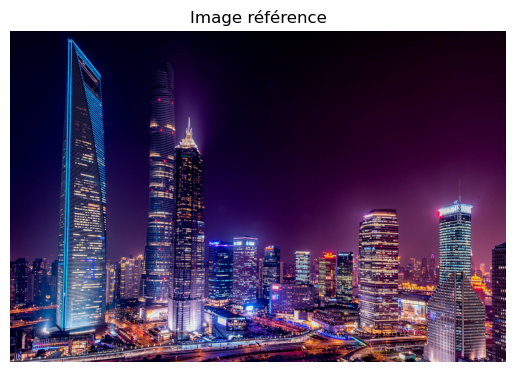

In [7]:
path_ref = './picture_city.jpg'
img_ref, mat_ref = import_image(path_ref)

print_image(img_ref, "Image référence")

### Vidéo étudiée

In [124]:
def extract_frames(path):
    """
    Récupère les images d'une vidéo
    Entrée: - path(str): Chemin pour accéder à la vidéo
    Sortie: - frames(list): Liste des images qui composent la vidéo
    """
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # récupère les images en RGB
        frames.append(frame_rgb.astype(np.float64) / 256)

    cap.release() # libère cap

    return frames

video_path = './video_city.mp4'
frames = extract_frames(video_path)

if frames is not None:
    print(f"Number of frames extracted: {len(frames)}")
else:
    print("Error extracting frames.")

Number of frames extracted: 304


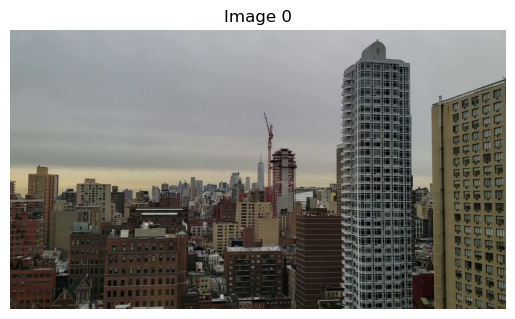

In [125]:
print_image(frames[0], 'Image 0')

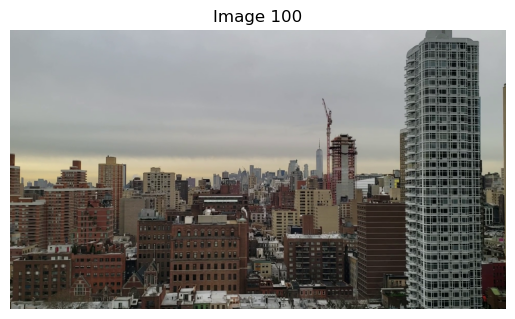

In [10]:
print_image(frames[100], 'Image 100')

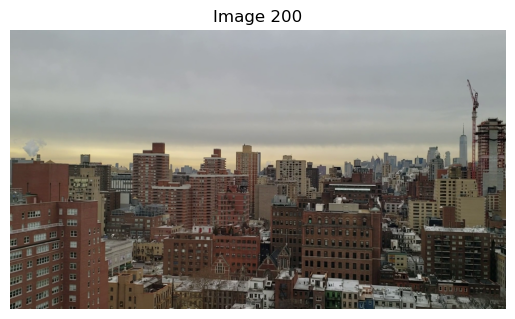

In [11]:
print_image(frames[200], 'Image 200')

## Transfert optimal

### Clustering (permet de diminuer le temps de calcul)

In [136]:
def clustering(X, model_clust):
    """
    Applique un clustering sur deux matrices d'images (Les valeurs de X doivent être entre 0 et 1).
    Entrées: - X1(matrice): Matrice de la première image
             - model_clust(model scikit learn): Modèle de clustering
    Sortie: - Xs(matrice): Matrice après le clustering
    """
    idx1 = rng.randint(X.shape[0], size=(500,))
    clust1 = model_clust.fit(X)
    Xs = np.clip(clust1.cluster_centers_,0,1) 
    return Xs

In [137]:
nb_samples = 1000
X_to_color = im2mat(frames[0]); X_color = im2mat(img_ref)
model = skcluster.MiniBatchKMeans(n_clusters=nb_samples, init_size = 3000)
Xs = clustering(X_to_color, model)
Xt = clustering(X_color, model)

C:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


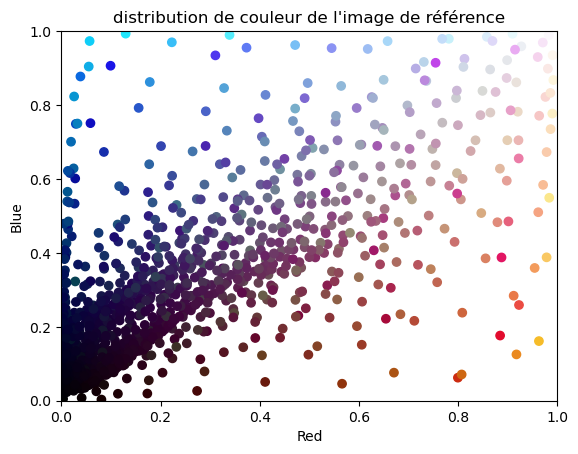

In [138]:
def plot_distribution(X, title):
    """
    Affiche la distribution des couleurs de la matrice en paramètre
    Entrées: - X(matrice): Matrice de l'image étudiée
             - title(str): Titre du graphe
    """
    plt.scatter(X[:, 0], X[:, 2], c=X)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Red')
    plt.ylabel('Blue')
    plt.title(title)
    plt.show()
    
plot_distribution(Xt, "distribution de couleur de l'image de référence")

### Application du transport optimal

In [146]:
def tran_opt(Xs, Xt, X, img_shape, method = "emd"):
    """
    Applique le transfert optimal sur une image X en fonction de l'algorithme choisi par l'utilisateur
    Entrées: - Xs(matrice): Matrice après clustering de l'image à colorer
             - Xt(matrice): Matrice après clustering de l'image référence
             - X(matrice): Matrice de l'image à colorer
             - img_shape(shape): Dimension de l'image à colorer
             - method(str): Modèle de transport optimal utilisé (EMD par défaut)
    Sortie: - Image recolorisée
    """
    if method == "emd":
        ot_model = ot.da.EMDTransport()
    elif method == "sinkhorn":
        ot_model = ot.da.SinkhornTransport(reg_e=1e-1)
    elif method == "linear":
        ot_model = ot.da.MappingTransport(
            mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True)
    elif method == "gaussian":
        ot_mapping_gaussian = ot.da.MappingTransport(
            mu=1e0, eta=1e-2, sigma=1, bias=False, max_iter=10, verbose=True)
    else:
        print("Les quatres choix de modèles sont : \n- 'emd' : EMDTransport \n-'sinkhorn': SinkhornTransport \n-'linear': Mapping linéaire \n-'gaussian': Mapping Gaussien")
        return None
        
    ot_model.fit(Xs=Xs, Xt=Xt)
    transp_Xs = ot_model.transform(Xs=X)
    img = minmax(mat2im(transp_Xs, img_shape))
    return img

In [148]:
img = tran_opt(Xs, Xt, X_to_color, frames[0].shape)

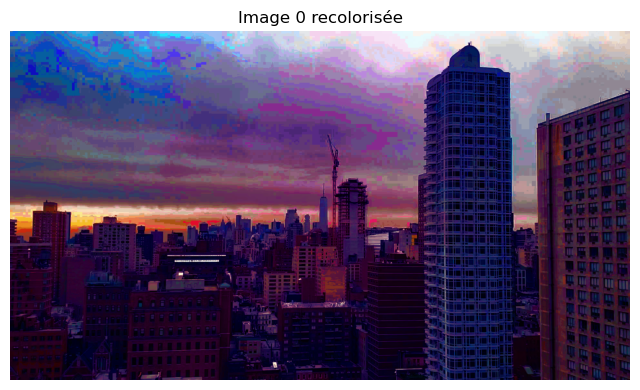

In [149]:
def showImage(img, title):
    """
    Affiche une image avec un titre associé
    Entrées: - img(image): Image à afficher
             - title(str): Titre de l'image
    """
    pl.figure(figsize=(8,8))
    pl.imshow(img)
    pl.axis('off')
    pl.title(title)
    pl.show()

showImage(img, 'Image 0 recolorisée')